In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import qriemannopt as qro

C:\Users\HYPERPC\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


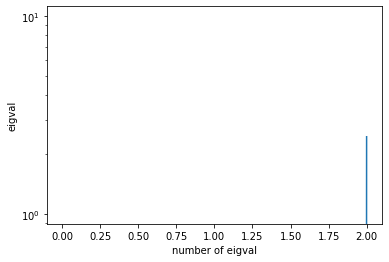

In [2]:
ham_dim = 3 # dimension of hamiltonian

# hamiltonian
Q = qro.manifold.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)
S = tf.random.uniform((ham_dim,), -3, 3)
#S = tf.exp(S)
S = tf.cast(S, dtype=tf.complex128)
H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

plt.plot(tf.linalg.eigvalsh(H))
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('eigval')

# min of loss function
min_value = tf.cast(tf.linalg.eigvalsh(H)[0],
                   dtype=tf.float64)

# in dens matrix
rho = tf.eye(ham_dim, dtype=tf.complex128)
rho = rho / tf.linalg.trace(rho)
rho = qro.manifold.complex_to_real(rho)

# manifold of dens matrices
m = qro.manifold.DensM()

# optimizers
opts = {
        'GD':qro.optimizers.RSGD(m, 0.01),
        'GD_momentum':qro.optimizers.RSGD(m, 0.01, 0.9),
        'Adam':qro.optimizers.RAdam(m, 0.01),
        'Adam_with_ams':qro.optimizers.RAdam(m, 0.01, ams=True)
       }

In [3]:
list_of_losses = {}
# loop over optimizers
for key, opt in opts.items():
    # training loop
    losses = []
    rho_var = tf.Variable(rho)
    for _ in range(300):
        with tf.GradientTape() as tape:
            loss = tf.linalg.trace(qro.manifold.real_to_complex(rho_var) @ H)
            loss = tf.cast(loss, tf.float64)
            losses.append(loss - min_value)
        grad = tape.gradient(loss, rho_var)
        opt.apply_gradients(zip([grad], [rho_var]))
    list_of_losses[key] = losses

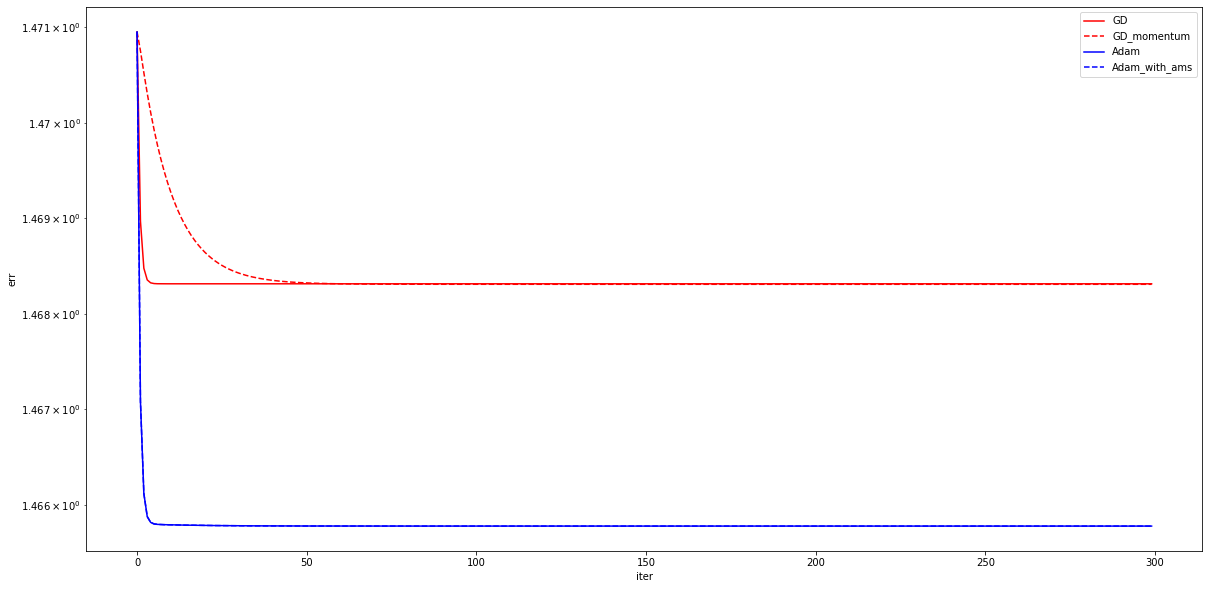

In [4]:
# learning curves
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--', 'r:', 'r-.', 'b:', 'b-.', 'k:', 'k-.', 'g:', 'g-.', 'purple']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(list_of_losses[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')
plt.savefig('Riemann_opt_first_test.pdf')

In [ ]:
rho_c = qro.manifold.real_to_complex(rho_var)
grad_c = qro.manifold.real_to_complex(grad)
rgrad = m.egrad_to_rgrad(rho_c, grad_c)

In [ ]:
tf.linalg.eigvalsh(rho_c)

In [2]:
m = qro.manifold.DensM()

In [3]:
rho = qro.manifold.real_to_complex(tf.random.normal((3, 3, 3, 2), dtype=tf.float64))
rho = rho @ tf.linalg.adjoint(rho)

v = qro.manifold.real_to_complex(tf.random.normal((3, 3, 3, 2), dtype=tf.float64))
v = v + tf.linalg.adjoint(v)
v = v - tf.eye(v.shape[-1], dtype=tf.complex128) * tf.linalg.trace(v)[..., tf.newaxis, tf.newaxis] / v.shape[-1]

u = qro.manifold.real_to_complex(tf.random.normal((3, 3, 3, 2), dtype=tf.float64))
u = u + tf.linalg.adjoint(u)
u = u - tf.eye(u.shape[-1], dtype=tf.complex128) * tf.linalg.trace(u)[..., tf.newaxis, tf.newaxis] / u.shape[-1]

In [4]:
m.inner(rho, v, v)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 24)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected indent (<unknown>, line 24)


<tf.Tensor: shape=(3,), dtype=complex128, numpy=
array([ 56.32984017+9.80626691e-16j, 228.32960112-2.26476364e-13j,
        49.90756749-1.43013399e-15j])>

In [8]:
rho_c

<tf.Tensor: shape=(3, 3), dtype=complex128, numpy=
array([[nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj]])>